In [1]:
"""
The method for this comes from 

xhttps://cprosenjit.medium.com/multivariate-time-series-forecasting-using-xgboost-1728762a9eeb
"""

'\nThe method for this comes from \n\nxhttps://cprosenjit.medium.com/multivariate-time-series-forecasting-using-xgboost-1728762a9eeb\n'

In [2]:
import numpy as np
import xgboost
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_importance
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def format_data(path):
    df = pd.read_excel(path)
    df2 = df.drop(columns=['Country Name', 'Country Code'])
    df2 = df2.dropna(axis=1, how='all')
    
    #Have to shift GDP Growth to last column because that will be the target
    #Refactored from stackoverflow
    df3 = df2[[column for column in df2 if column not in ['GDP growth (annual %)']] + ['GDP growth (annual %)']]
    
    return df3

In [5]:
def fill_na(data):
    
    df4 = data.fillna(data.mean())
    
    return df4

In [6]:
def x_and_y(data):
    
    X = data.iloc[:,:-1]
    y = data.iloc[: ,-1]
    
    return X, y

In [7]:
def train_test_split_func(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
    
    return X_train, X_test, y_train, y_test

In [8]:
def xgb(X_train, y_train, X_test):
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=6, learning_rate=0.3)
    model.fit(X_train, y_train)
            
    y_pred = model.predict(X_test)
    
    return model, y_pred

In [9]:
def scale(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    return X_train_s, X_test_s

In [10]:
def feature_selection(model, X_train, X_test, y_train):
    
    selector = SelectFromModel(model, threshold=0.003)
    selector.fit (X_train, y_train)
    
    select_X_train = selector.transform(X_train)
    select_X_test = selector.transform(X_test)
    
    #print (selector.get_feature_names_out())
    
    selection_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=6, learning_rate = 0.3)
    selection_model.fit(select_X_train, y_train)
    
    select_y_pred = selection_model.predict(select_X_test)
    
    selection_model.get_booster().feature_names = selector.get_feature_names_out().tolist()
    plot_importance(selection_model.get_booster())
    
    return select_y_pred

In [11]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [12]:
#Get the data
data = format_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Multivariate More.xlsx')

In [13]:
#Fill all NA with mean imputation
filled = fill_na(data)

In [14]:
filled = filled.set_index('Year')

In [15]:
#Getting the features
X, y = x_and_y(filled)

In [16]:
#Split into train test
X_train, X_test, y_train, y_test = train_test_split_func(X, y)

In [17]:
#Scale
X_train_scaled, X_test_scaled = scale(X_train, X_test)

In [18]:
#Make prediction before feature selection
model, y_pred = xgb(X_train_scaled, y_train, X_test_scaled)

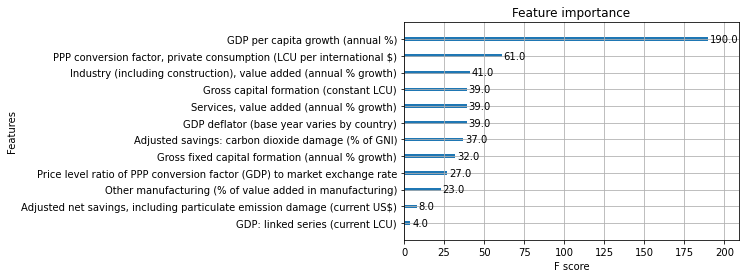

In [19]:
select_y_pred = feature_selection(model, X_train, X_test, y_train)

RMSE:  0.3103662444992456
MAPE:  4.710847116842862
MAE:  0.2469304641813189
Scatter Index:  5.759216088457039
MDA:  0.75
Mean of actual:  5.389036280845581


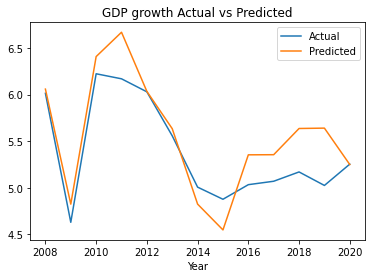

In [20]:
#Outputs
df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : select_y_pred})
df_compare.plot(title='GDP growth Actual vs Predicted')
performance_metrics(y_test, select_y_pred)

In [21]:
def tune_n_estimator(X, y):
    hyperparam = {'max_depth': [1,2,3,4,5,10],
                 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                 'n_estimators': [5,10,20,50,100,1000]}
    
    model = XGBRegressor()
    
    gscv = GridSearchCV(estimator=model, param_grid=hyperparam,
                       scoring='neg_mean_squared_error',
                       verbose=1)
    
    gscv.fit(X, y)
    
    print("best hyperparam:", gscv.best_params_)

In [22]:
#tune_n_estimator(X,y)